<img src="https://drive.google.com/uc?export=view&id=1GxcB09pWggi2b7ZTfeSn4toiMoo5qTxd" alt="2024 IEEE GRSS Data Fusion Contest" />

# 2024 IEEE GRSS Data Fusion Contest 
# Track 2: Flood rapid mapping with optical data - Starting Kit

## Introduction

Track-2 focuses on mapping the water surface from Copernicus Sentinel-2 and Landsat optical imageries. The goal is to accurately determine water and non-water pixels in these event areas by fusing data from one or more of the provided data sources.

## I. Exploratory data analysis

### I. 1. How to open and plot what the raster images and masks looks like

In [63]:
import glob
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import rasterio

In [64]:
path_images="./Codalab/track_2/images/"
path_masks="./Codalab/track_2/masks/"

In [65]:
# Set the path to the images and labels directory and load the images and masks filenames
img_files = glob.glob(os.path.join(path_images, '*.tif'))
msk_files = glob.glob(os.path.join(path_masks, '*.png'))

print("number of images = ", len(img_files))

img_files.sort()
msk_files.sort()
print("img_files =", img_files)
print("msk_files =", msk_files)

number of images =  5
img_files = ['./Codalab/track_2/images/123.tif', './Codalab/track_2/images/198.tif', './Codalab/track_2/images/271.tif', './Codalab/track_2/images/345.tif', './Codalab/track_2/images/433.tif']
msk_files = ['./Codalab/track_2/masks/123.png', './Codalab/track_2/masks/198.png', './Codalab/track_2/masks/271.png', './Codalab/track_2/masks/345.png', './Codalab/track_2/masks/433.png']


**Remark:** as the water masks have pixels value either at 0 or 1 but the possible values are between 0-255, they can appear totally black on a visualization tool without dynamics. But you can still see the masks using a notebook or a specialized softare such as QGIS.

An example below on how to open and plot a water mask image :

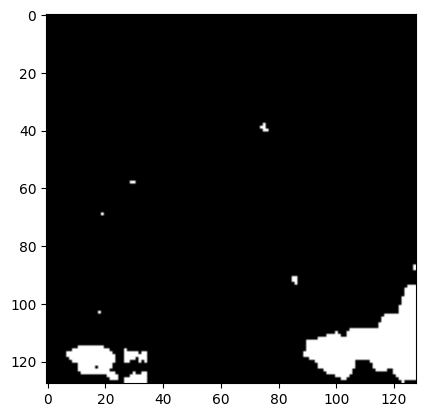

In [66]:
# plot the water mask 
gray = cv2.imread(msk_files[1], cv2.IMREAD_UNCHANGED)
plt.imshow(gray,  cmap='gray')

And how to plot the associated SAR image, VV (first spectral band).

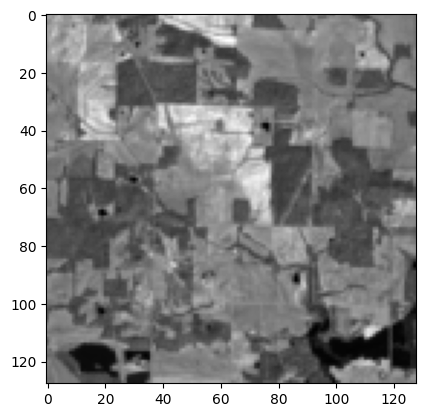

In [67]:
# plot the NIR band
img=rasterio.open(img_files[1]).read(5)
plt.imshow(img, cmap='gray')

And to have a quick look on the different data, an example below of what you can plot:

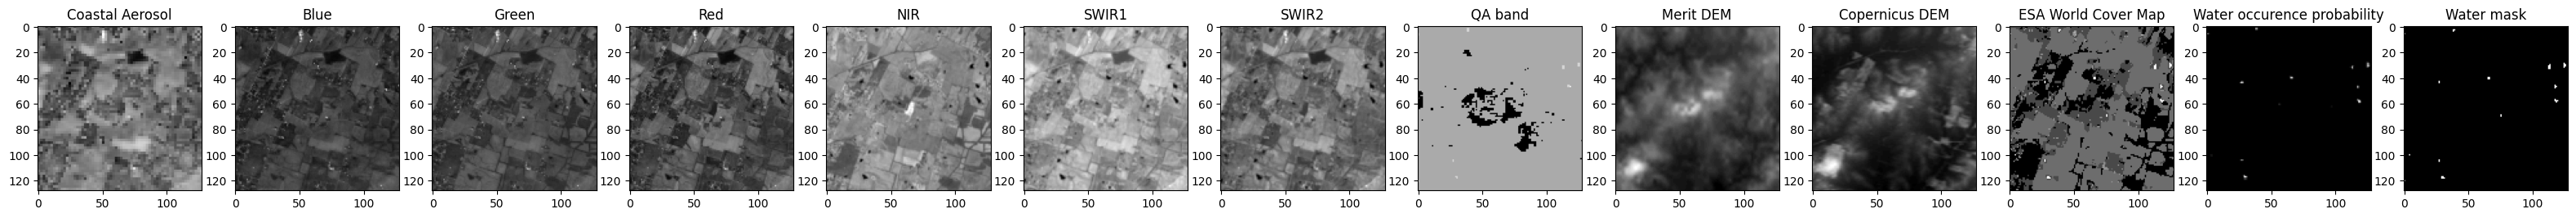

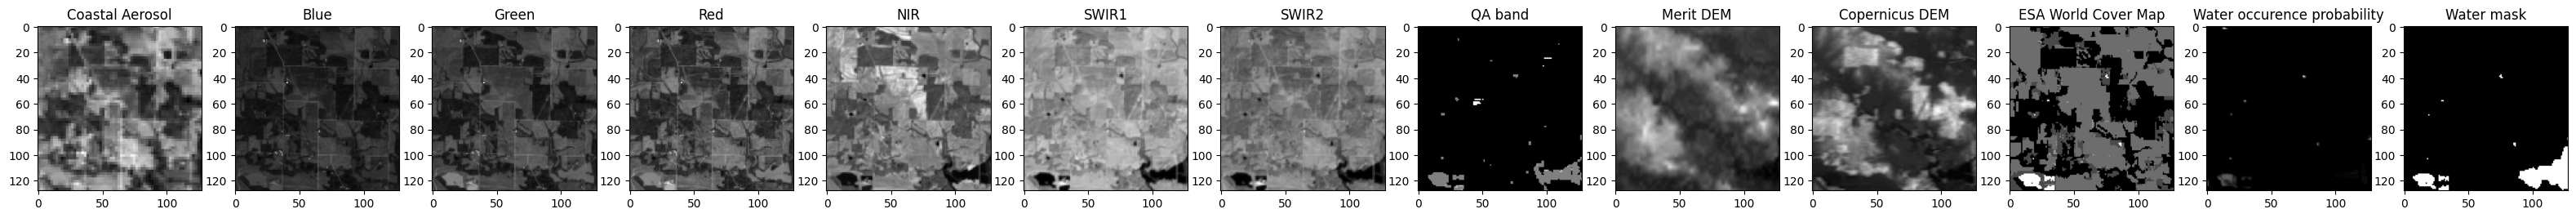

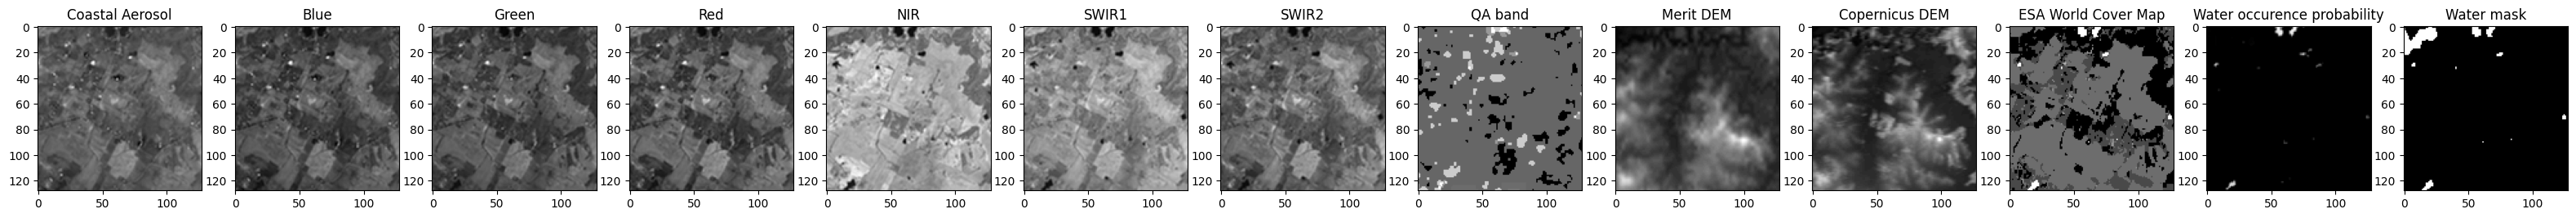

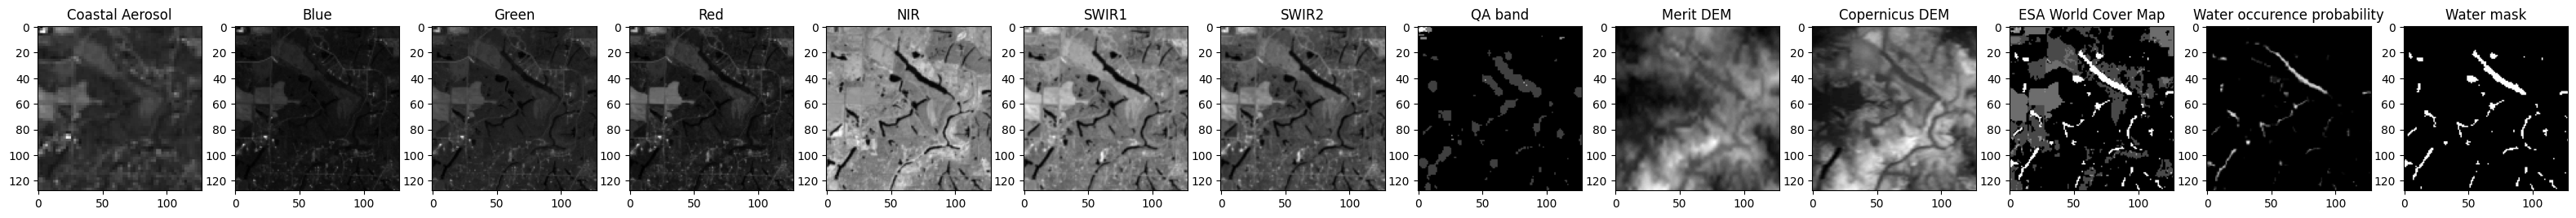

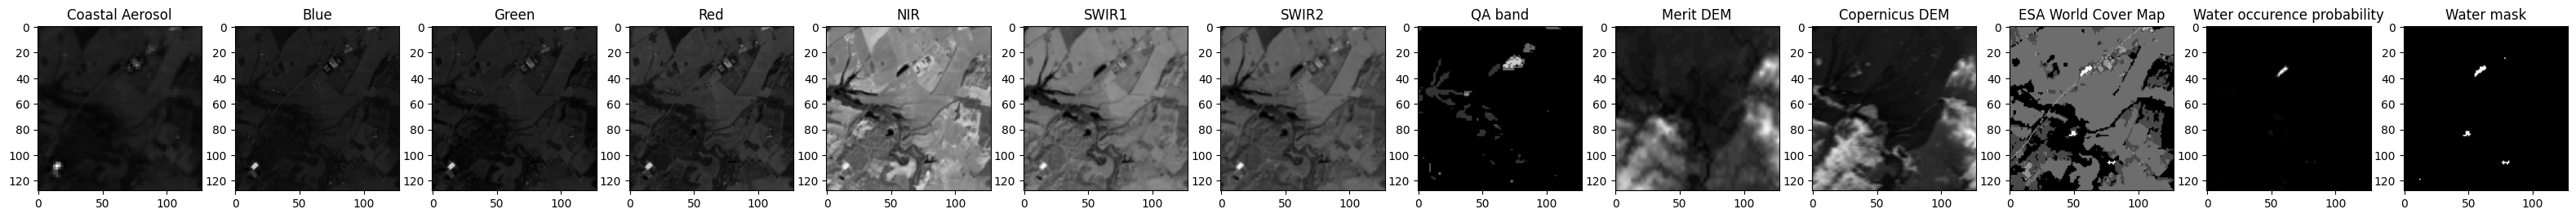

In [68]:
for i in range(len(img_files)):
    path_msk=msk_files[i]
    path_img=img_files[i]
    #print("path_msk = ", path_msk)
    #print("path_img = ", path_img)
    
    # Water mask (.png file)
    mask = cv2.imread(path_msk, cv2.IMREAD_UNCHANGED)
    
    # Spectral bands inside each .tif file
    img1 = rasterio.open(path_img).read(1)
    img2 = rasterio.open(path_img).read(2)
    img3 = rasterio.open(path_img).read(3)
    img4 = rasterio.open(path_img).read(4)
    img5 = rasterio.open(path_img).read(5)
    img6 = rasterio.open(path_img).read(6)
    img7 = rasterio.open(path_img).read(7)
    img8 = rasterio.open(path_img).read(8)
    img9 = rasterio.open(path_img).read(9)
    img10 = rasterio.open(path_img).read(10)
    img11 = rasterio.open(path_img).read(11)
    img12 = rasterio.open(path_img).read(12)

    fig, ax = plt.subplots(1, 13, figsize=(40,20))
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2,  cmap='gray')
    ax[2].imshow(img3,  cmap='gray')
    ax[3].imshow(img4,  cmap='gray')
    ax[4].imshow(img5,  cmap='gray')
    ax[5].imshow(img6,  cmap='gray')
    ax[6].imshow(img7,  cmap='gray')
    ax[7].imshow(img8,  cmap='gray')
    ax[8].imshow(img9,  cmap='gray')
    ax[9].imshow(img10,  cmap='gray')
    ax[10].imshow(img11,  cmap='gray')
    ax[11].imshow(img12,  cmap='gray')
    ax[12].imshow(mask,  cmap='gray')
    
    # Set a title for the figures
    ax[0].set_title('Coastal Aerosol')
    ax[1].set_title('Blue')
    ax[2].set_title('Green')
    ax[3].set_title('Red')
    ax[4].set_title('NIR')
    ax[5].set_title('SWIR1')
    ax[6].set_title('SWIR2')
    ax[7].set_title('QA band')
    ax[8].set_title('Merit DEM')
    ax[9].set_title('Copernicus DEM')
    ax[10].set_title('ESA World Cover Map')
    ax[11].set_title('Water occurence probability')
    ax[12].set_title('Water mask')

## II. Testing approach based on a spectral index : NDWI

The Normalized Difference Water Index (NDWI) is a common spectral index used to highlight open water features in a satellite image, allowing a water area to stand out against the other types of ground cover.

It is defined as follow:

**NDWI = (Green – NIR)/(Green + NIR)**


The NDWI values correspond to the following ranges:

- [0,2 ; 1] –> Water surface,
- [0.0 ; 0,2] –> Flooding, humidity,
- [-0,3 ; 0.0] –> Moderate drought, non-aqueous surfaces,
- [-1 ; -0.3] –> Drought, non-aqueous surfaces
    

Let's see the kind of result such an approach can give in our case.


In [69]:
def compute_NDWI(path_input_img):
    with rasterio.open(path_input_img) as dataset:
        green = dataset.read(3)
        nir = dataset.read(5)
        
        # Conversion from uint16 to float
        GREEN = np.float32(green)  # R = np.float32(R_U)
        NIR = np.float32(nir)  # NIR = np.float32(NIR_U)

        #print('np.amin(R) = ', np.amin(GREEN), ' ; np.amax(R) = ', np.amax(NIR))
        #print('np.amin(NIR) = ', np.amin(NIR), ' ; np.amax(NIR) = ', np.amax(NIR))

        # # if the denominateur = 0, we don't calculate the NDVI, otherwise it's ok
        NDWI = np.divide((GREEN - NIR), (GREEN + NIR), where=(NIR + GREEN) != 0)

        #print("type(NDWI[0,0]) = ", type(NDWI[0, 0]))
        #print('np.amin(NDWI) = ', np.amin(NDWI))
        #print('np.amax(NDWI) = ', np.amax(NDWI))

    return NDWI

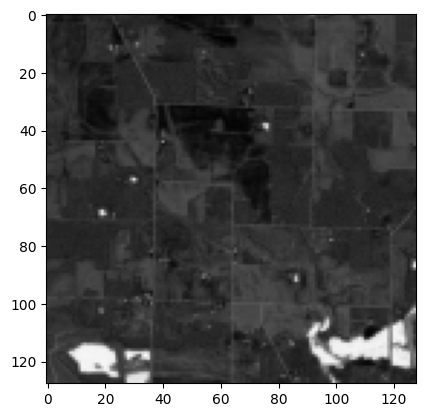

In [70]:
NDWI = compute_NDWI(img_files[1])
plt.imshow(NDWI, cmap='gray')

Since the water surface corresponds to NDWI values between [0,2 ; 1], an additional thresholding step can be added in order to get a mask :
- if the value is in [0,2 ; 1] -> the pixel is set to 1
- otherwise -> the pixel is set to 0.

In [71]:
def threshold(input_NDWI, min_limit):
    thresh = np.where(input_NDWI >= min_limit, 1, 0)
    return thresh

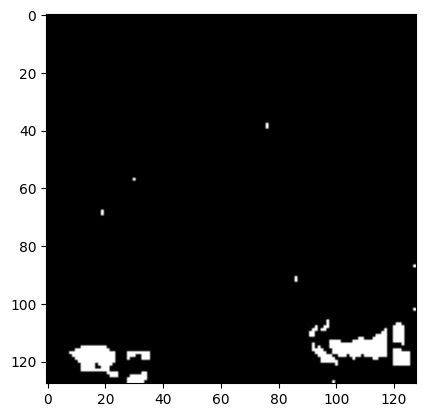

In [72]:
NDWI = compute_NDWI(img_files[1])
thr = threshold(NDWI, 0.2)

plt.imshow(thr, cmap='gray')

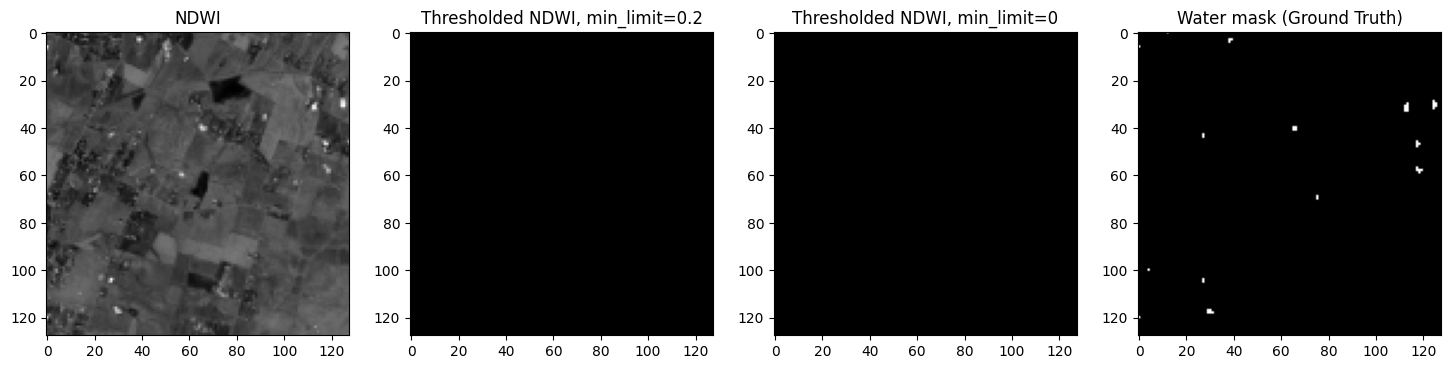

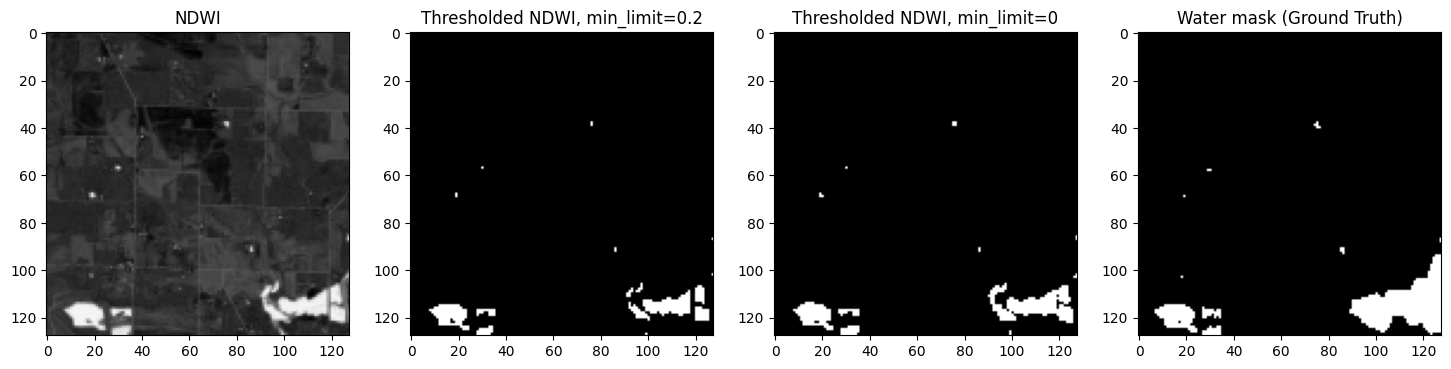

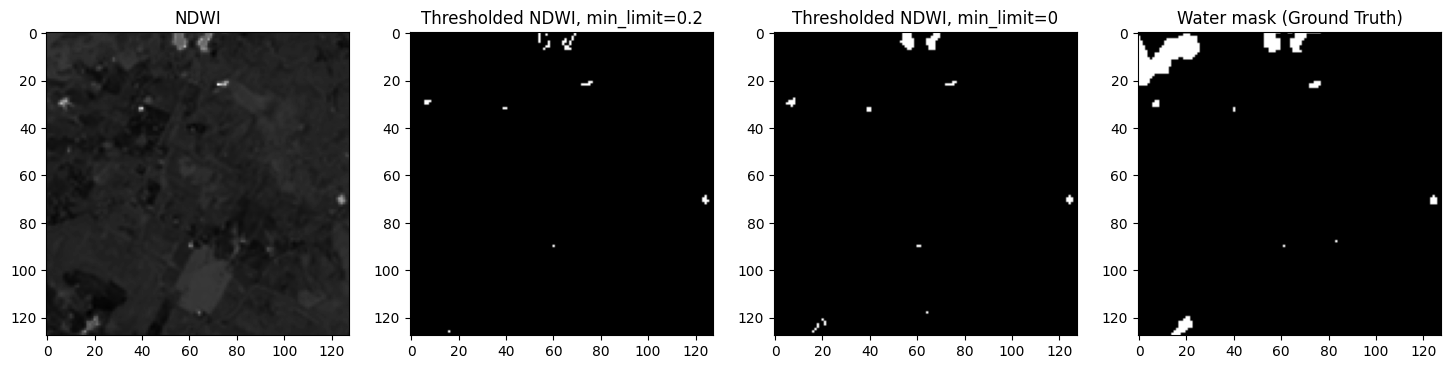

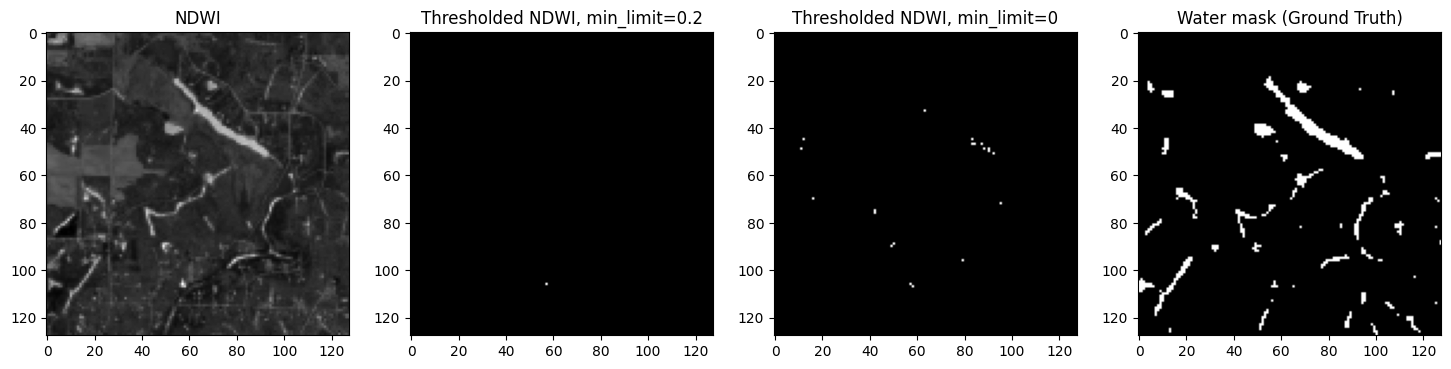

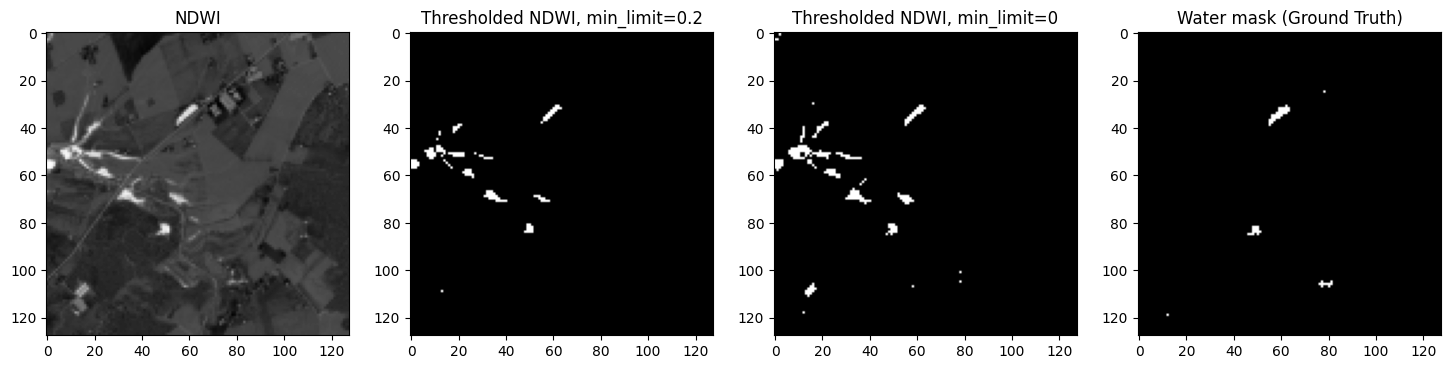

In [74]:
for i in range(len(img_files)):
    path_img=img_files[i]
    path_msk=msk_files[i]
    
    # Water mask (.png file)
    mask = cv2.imread(path_msk, cv2.IMREAD_UNCHANGED)
    
    # Spectral bands inside each .tif file
    NDWI = compute_NDWI(path_img)
    thr_02 = threshold(NDWI, 0.2)
    thr_0 = threshold(NDWI, 0.)
    
    fig, ax = plt.subplots(1, 4, figsize=(18,9))
    ax[0].imshow(NDWI, cmap='gray')
    ax[1].imshow(thr_02,  cmap='gray')
    ax[2].imshow(thr_0,  cmap='gray')
    ax[3].imshow(mask,  cmap='gray')
    
    # Set a title for the figures
    ax[0].set_title('NDWI')
    ax[1].set_title('Thresholded NDWI, min_limit=0.2')
    ax[2].set_title('Thresholded NDWI, min_limit=0')
    ax[3].set_title('Water mask (Ground Truth)')


Trying to decrease the minimum value from 0.2 to 0. in the threshold function does not improve in each cases the obtained water mask.

Since the flood mapping task is complex and as illustrated with a simple approach based on spectral index such as NDWI, it is more appropriate to try deep learning methods.

Participants are encouraged to test various deep learning approaches to see which one is the best. Data augmentation is also a good practice.

## III. Preparing the submission

As described in the challenge, the task consists of a binary water / non-water pixel-wise classification. Participants will submit rapid flood maps to the codalab server. 
Flood maps shall be a .png product where individual pixels are labeled water (1), or non-water (0). The flood map will have the same grid and resolution as the identified test data file.

Classification accuracy will be evaluated against a test subsample of the reference dataset, which will not be provided to participants. The F1-score metric will be used to rank the results. 
The algorithm with the highest F1-score on the Phase 2 test set will be the winner.

The expected format of the submission is a zip file containing directly the obtained .png masks (labeled water (1), or non-water (0)); files should not be stored in a directory in the zip archive. 
Participants must keep the same id at the beginning of the submitted file as the corresponding id of the raster image and the water mask ("id.png"). For example for the image "25.tif" the name of the corresponding mask must start by "25" ; it could be "25.png" or "25_whatever.png", etc.

To create the .zip archive, you can proceed as below:

In [ ]:
# Assuming that the folder containing the files has the following path
path_masks = "/my/path/to/the/images/"

# Go in the directory
cd path_masks

# Build the .zip archive
zip -r ../name_of_your_zip_archive.zip *

# Participants can now upload their archive to Codalab !

If you have trouble to submit your results, make sure your .zip archive have the following architecture:

 ```
name_of_your_zip_archive.zip
|___ id1_msk.png
|___ id2_msk.png
|___ id3_msk.png
|___ id4_msk.png
|___ ... 
 ```

And not the followig:

 ```
name_of_your_zip_archive.zip
|___ name_of_your_zip_archive
     |___ id1_msk.png
     |___ id2_msk.png
     |___ id3_msk.png
     |___ id4_msk.png
     |___ ... 
 ```